In [1]:
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import sklearn.neighbors as nb

import bachelors_thesis.util as util

In [2]:
data_path = "../../data"

In [3]:
# Load cameras
cameras = list()
with open(f"{data_path}/dataset/cameras.json", mode="r", encoding="utf-8") as file:
    for line in file:
        camera = json.loads(line)
        cameras.append(
            {"camera_id": camera["camera_id"], "x": camera["position"][0], "y": camera["position"][1]})

cameras_dict = {camera["camera_id"]: camera for camera in cameras}

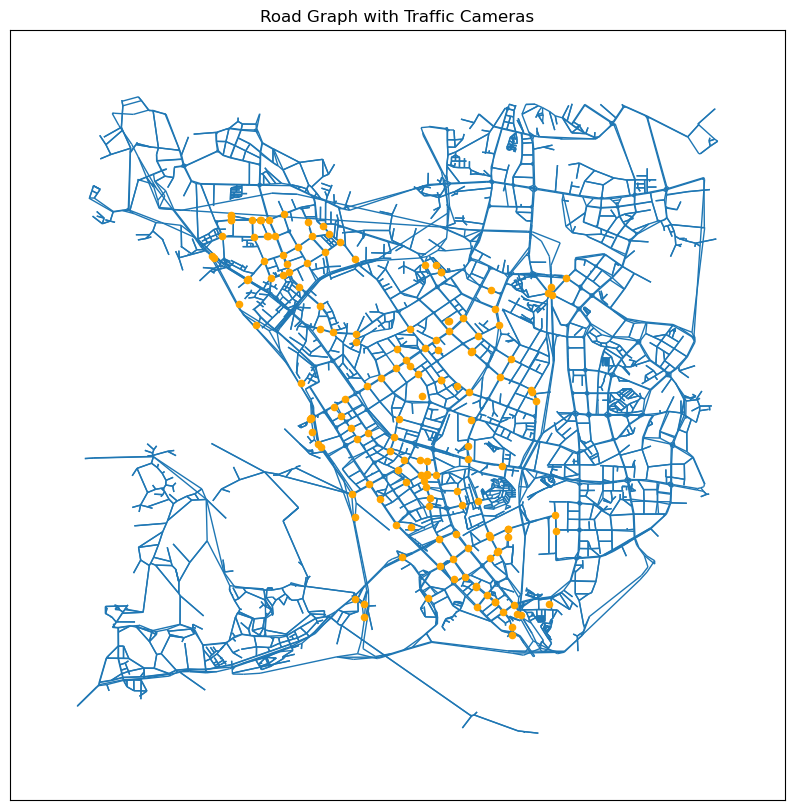

In [4]:
# Load road graph
road_graph = util.load_graph(f"{data_path}/road_graph/road_graph_ox_nsl_sim_sc.pickle")
road_graph = ox.project_graph(road_graph, to_crs=util.EPSG_32650)

# Project camera coordinates
for camera in cameras:
    x, y = camera["x"], camera["y"]
    proj_gps = util.xy_to_epsg4326(np.array([[x, y]]))
    proj_gps = util.epsg4326_to_epsg32650(proj_gps)
    lon, lat = proj_gps[0, 0], proj_gps[0, 1]
    camera["lon"] = lon
    camera["lat"] = lat

cameras_coordinates = np.array([[camera["lon"], camera["lat"]] for camera in cameras])

# Draw cameras on road graph
pos = {node: (road_graph.nodes[node]["x"], road_graph.nodes[node]["y"]) for node in road_graph.nodes()}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx_edges(
    road_graph,
    pos,
    edge_color="#1f77b4",
    arrows=False,
    ax=ax
)
ax.scatter(cameras_coordinates[:, 0], cameras_coordinates[:, 1], s=20, c="orange")
ax.set_title("Road Graph with Traffic Cameras")

plt.savefig(f"{data_path}/road_graph/road_graph_ox_nsl_sim_sc_cameras.svg")
plt.show()

Mean distance from camera to nearest node:  26.392699388375014
Median distance from camera to nearest node:  8.954999236549284


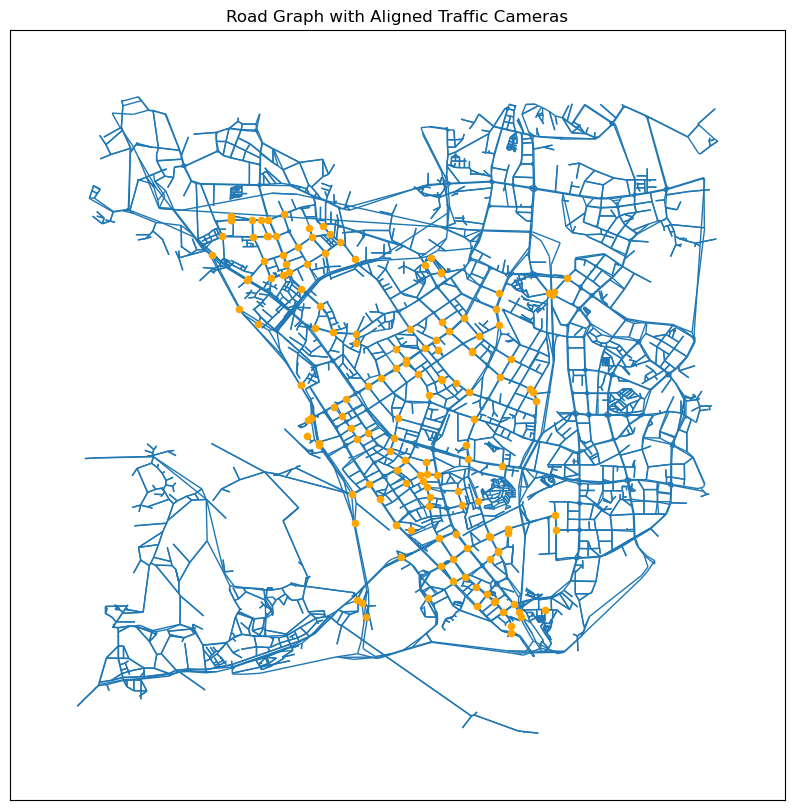

In [5]:
# Match cameras to nearest node
nodes = [{"node_id": node, "x": road_graph.nodes[node]["x"], "y": road_graph.nodes[node]["y"]} for node in
         road_graph.nodes()]
nodes_coordinates = np.array([[node["x"], node["y"]] for node in nodes])

kd_tree = nb.KDTree(nodes_coordinates)
distances, indices = kd_tree.query(cameras_coordinates, k=1, return_distance=True)
print("Mean distance from camera to nearest node: ", np.mean(distances))
print("Median distance from camera to nearest node: ", np.median(distances))
indices = indices.flatten()

for index, camera in zip(indices, cameras):
    camera["node_id"] = nodes[index]["node_id"]

# Draw aligned cameras on road graph
cameras_nodes = {camera["node_id"] for camera in cameras}
cameras_nodes_coordinates = np.array(
    [[road_graph.nodes[camera_node]["x"], road_graph.nodes[camera_node]["y"]] for camera_node in cameras_nodes])

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx_edges(
    road_graph,
    pos,
    edge_color="#1f77b4",
    arrows=False,
    ax=ax
)
ax.scatter(cameras_nodes_coordinates[:, 0], cameras_nodes_coordinates[:, 1], s=20, c="orange")
ax.set_title("Road Graph with Aligned Traffic Cameras")

plt.savefig(f"{data_path}/road_graph/road_graph_ox_nsl_sim_sc_cameras_aligned.svg")
plt.show()

In [6]:
# Save camera info
for camera in cameras_dict.values():
    del camera["lon"]
    del camera["lat"]

util.save(cameras_dict, f"{data_path}/road_graph/road_graph_ox_nsl_sim_sc_cameras.pickle")